In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style()

# Препроцессинг

Скачаем датасет с вином:

In [2]:
!wget -O data/raw/wine.csv https://www.openml.org/data/get_csv/3624/dataset_191_wine.arff

--2022-03-16 00:22:16--  https://www.openml.org/data/get_csv/3624/dataset_191_wine.arff
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘data/raw/wine.csv’

data/raw/wine.csv       [ <=>                ]  10,73K  --.-KB/s    in 0s      

2022-03-16 00:22:16 (26,7 MB/s) - ‘data/raw/wine.csv’ saved [10988]



In [3]:
df = pd.read_csv('data/raw/wine.csv')

df.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Посмотрим на данные внимательно:

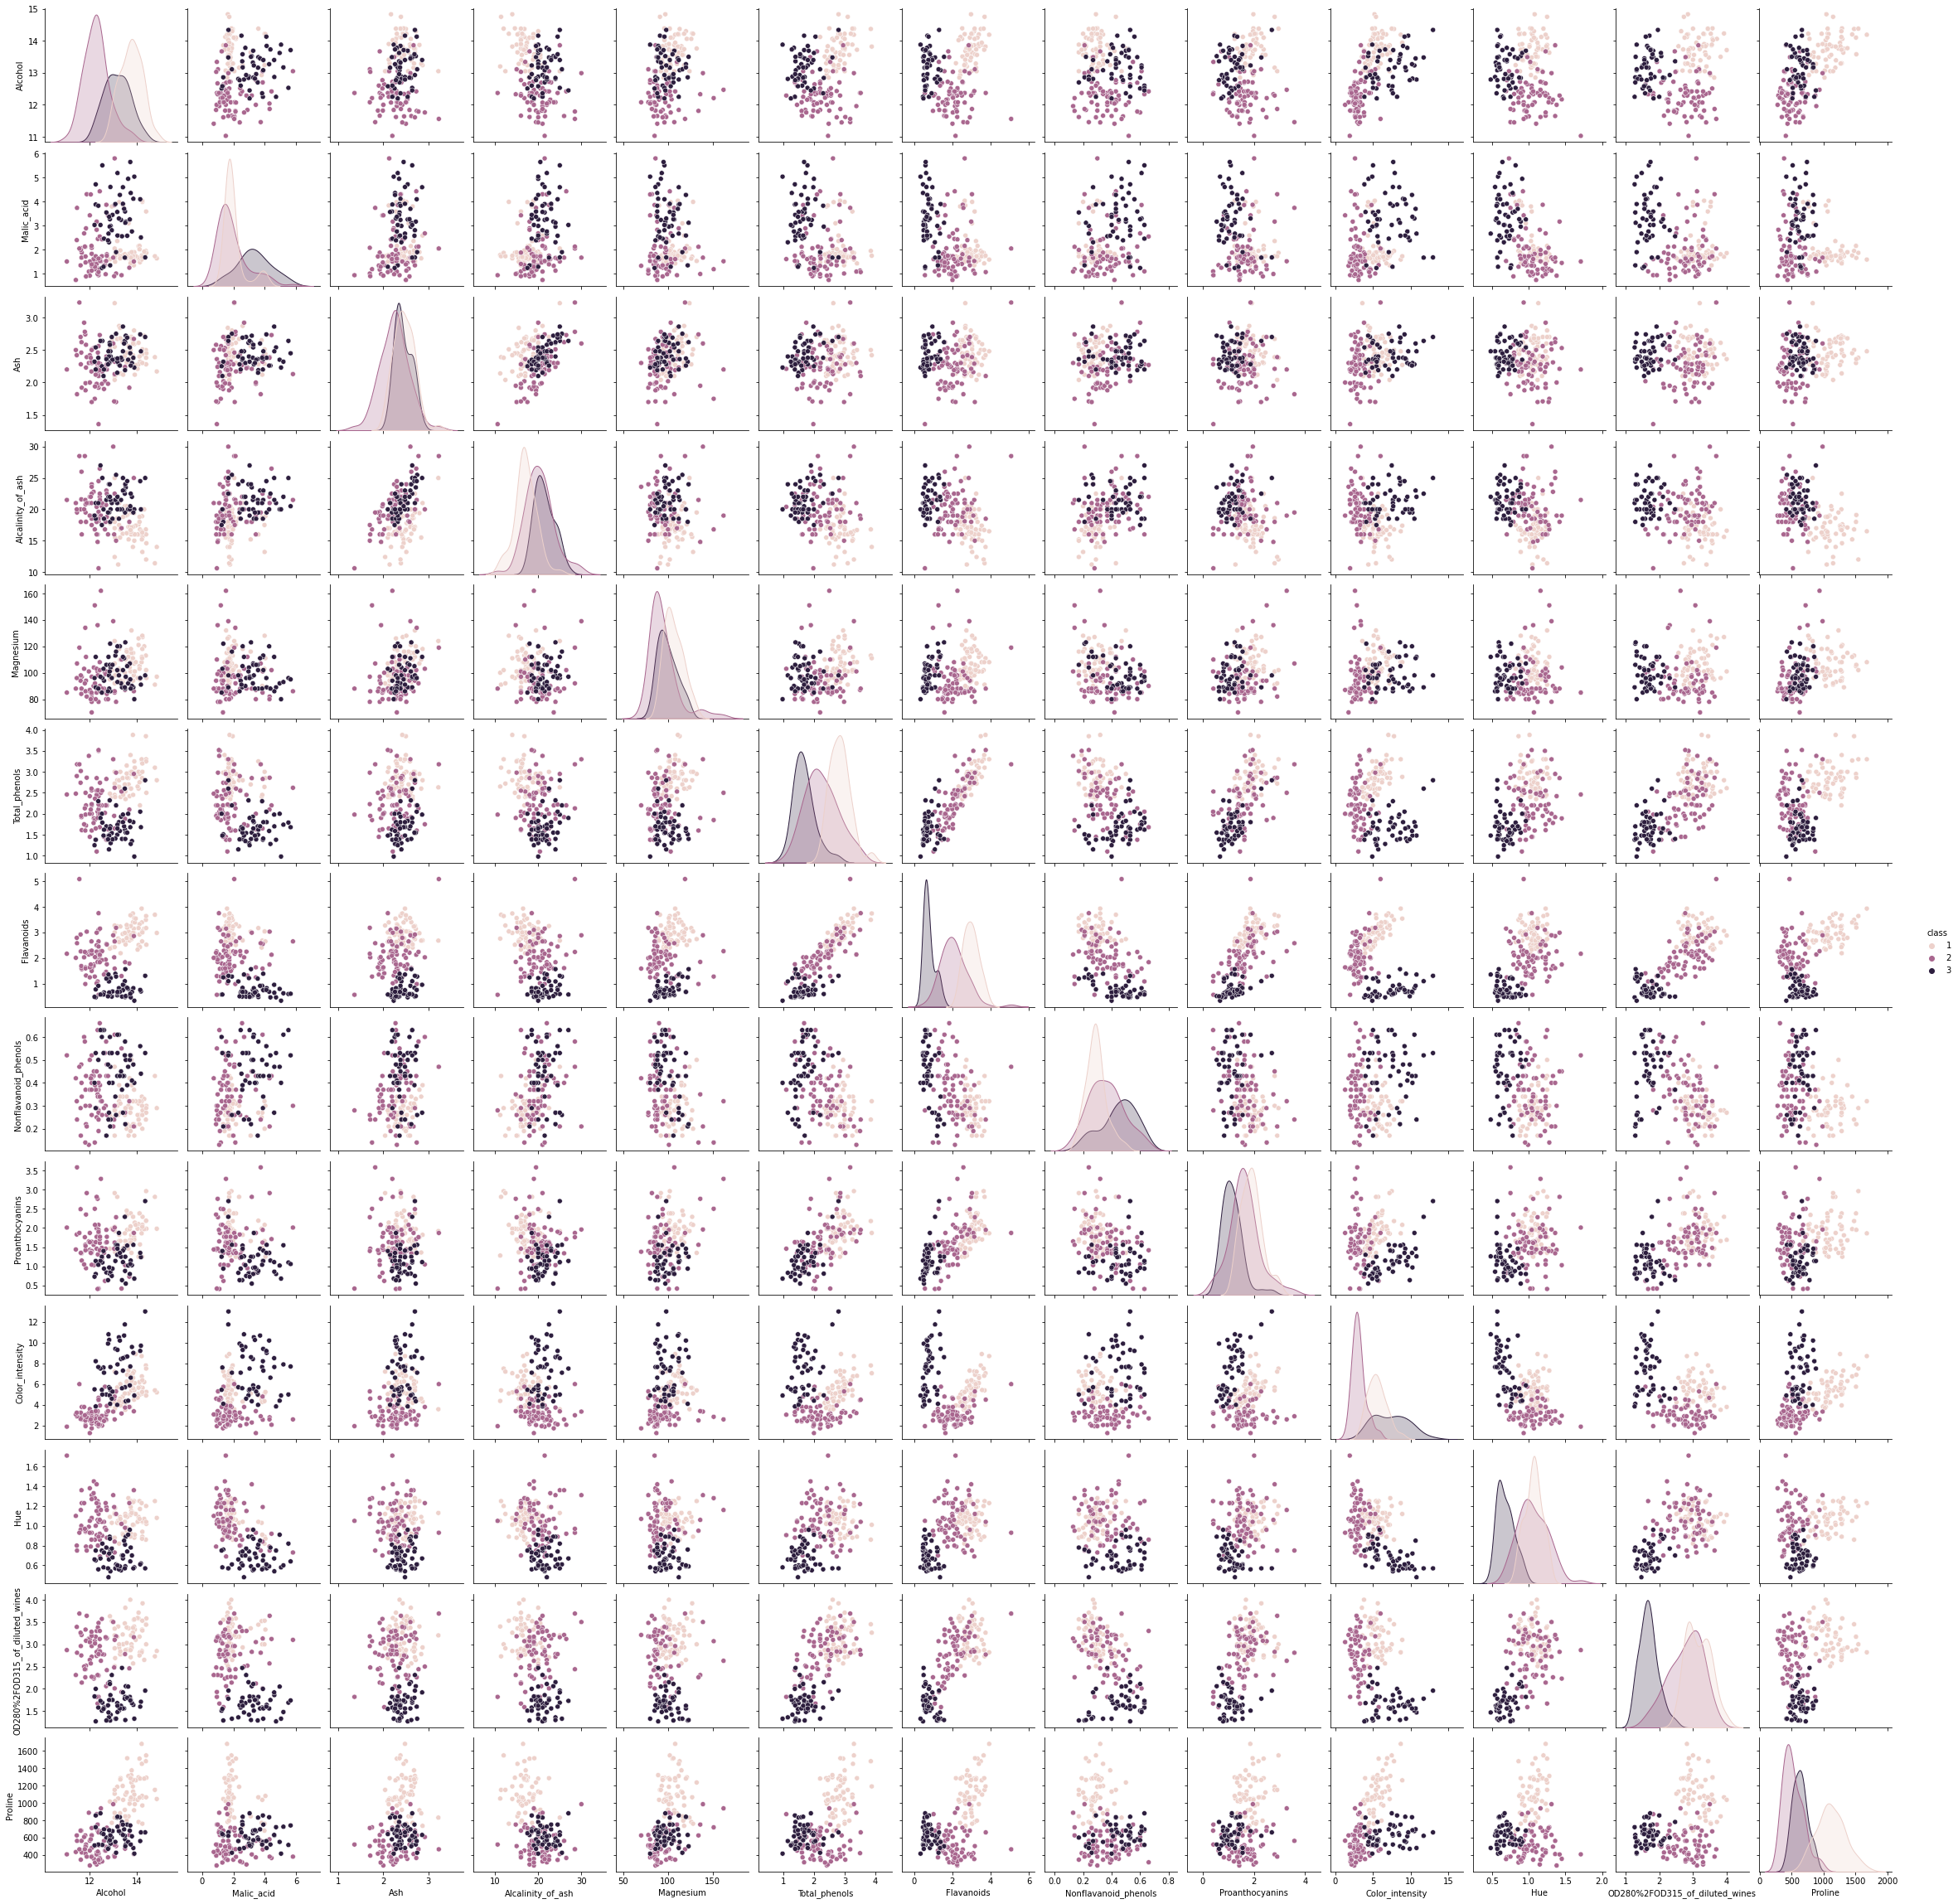

In [4]:
sns.pairplot(df, hue='class')

Как можно видеть, гипотеза о непрерывности выполняется на достаточно многих графиках.

Давайте теперь сделаем One-Hot Encoding для выходных данных. Но перед этим определим общий интерфейс для всех любых трансформаций:

In [5]:
# for 'return self'
from __future__ import annotations

class BasicLayer:
    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> BasicLayer:
        return self
    
    def transform(self, X: pd.DataFrame, inplace: bool = False) -> pd.DataFrame:
        return X if inplace else X.copy()
    
    def fit_transform(self, X: pd.DataFrame, y: pd.DataFrame, inplace: bool = False) -> pd.DataFrame:
        return self.fit(X, y).transform(X, inplace=inplace)

Дизайн нагло украден из sklearn, однако немного упрощён и в дальнейшем будет крайне удобен.

In [6]:
from typing import Set

class OneHotEncoder(BasicLayer):
    def __init__(self, column: str):
        self.column = column
        self.values: Set[str] = set()
    
    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> OneHotEncoder:
        # Record all the different values seen in the given column
        self.values = self.values.union(set(X[self.column].to_numpy()))
        return self
    
    def transform(self, X: pd.DataFrame, inplace: bool = False) -> pd.DataFrame:
        result = X.drop(self.column, axis=1, inplace=inplace)
        
        for value in self.values:
            result[f'{self.column}_is_{value}'] = (X[self.column] == value).astype('int32')
        
        return result

Проверим, как сработало:

In [7]:
# Not a real usage of course
OneHotEncoder('class').fit_transform(df, df)

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline,class_is_1,class_is_2,class_is_3
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,0,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,0,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,0,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,0,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,0,0,1
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,0,0,1
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,0,0,1
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,0,0,1


Как можно видеть, если бы нам пришлось энкодить ещё и признаки (здесь не придётся), то мы бы тоже легко справились при помощи этого шага пайплайна.

In [8]:
X, y = df.drop('class', axis=1), df[['class']]

y.to_csv('data/processed/labels.csv', index=False)

X.to_csv('data/processed/features.csv', index=False)